In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from functools import reduce
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import logistic_regression_helper as helper
from itertools import compress

sns.set_style("white")
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
base_d = "/Users/erankotler/dinamo"
data_d = os.path.join(base_d, "data/gse_data_20231002")

results_d = os.path.join(base_d, "resutls")

In [3]:
gse_acc = "GSE111629"
gse_d = os.path.join(data_d, gse_acc)

In [4]:
groups = pd.read_csv(os.path.join(gse_d, "groups.csv"), index_col=0)
pheno = pd.read_csv(os.path.join(gse_d, "phenotypes.csv"), index_col=1)
mat = pd.read_csv(os.path.join(gse_d, "matrix_beta.tsv"), index_col=0, sep="\t")#, nrows=100000)

In [5]:
print(mat.shape)
mat.head(3)

(486427, 571)


,GSM3035401,GSM3035402,GSM3035403,GSM3035404,GSM3035405,GSM3035406,GSM3035407,GSM3035408,GSM3035409,GSM3035410,...,GSM3035963,GSM3035964,GSM3035965,GSM3035966,GSM3035967,GSM3035968,GSM3035969,GSM3035970,GSM3035971,GSM3035972
cg00000029,0.560791,0.529685,0.551299,0.523617,0.497086,0.682066,0.696014,0.381508,0.335993,0.636045,...,0.743319,0.705104,0.483614,0.614315,0.487836,0.544218,0.479263,0.568623,NaN,0.479038
cg00000108,0.977816,0.972868,0.971075,0.972180,0.968020,0.972961,0.970523,0.966254,0.970028,0.975788,...,0.965072,0.973040,0.969568,0.971090,0.971595,0.966414,0.967109,0.974316,0.962038,0.966607
cg00000109,0.913741,0.920333,0.899200,0.930867,0.918766,0.916308,0.908068,0.914088,0.931169,0.918921,...,0.906061,0.923288,0.926353,0.917243,0.926034,0.897962,0.884515,0.906575,0.897299,0.901615


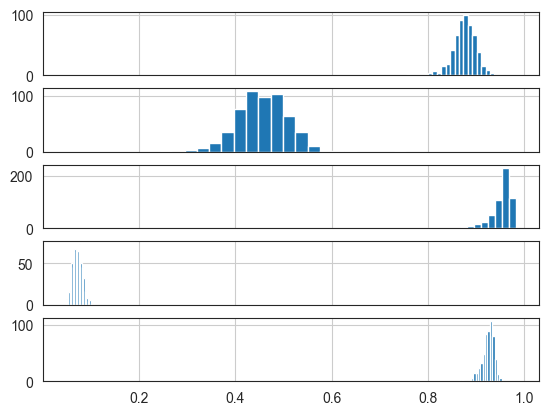

In [6]:
f, axs = plt.subplots(nrows=5, sharex=True)
for i, cg in enumerate([10,100,5780,702, 800]):
    mat.iloc[cg].hist(bins=20, ax = axs[i])
plt.show()

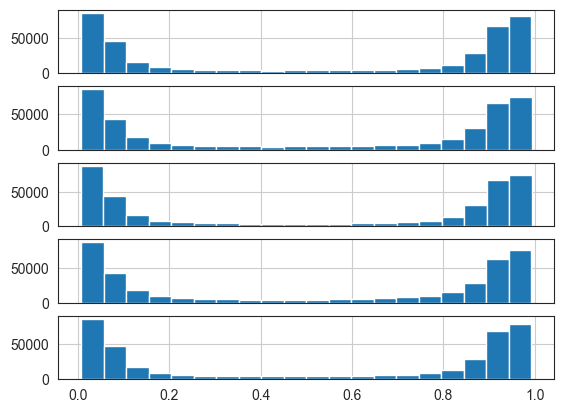

In [7]:
f, axs = plt.subplots(nrows=5, sharex=True)
for i, samp in enumerate(mat.columns[:5]):
    mat.loc[:, samp].hist(bins=20, ax = axs[i])
plt.show()

In [8]:
print(groups.shape)
groups.head(3)


(571, 1)


,Group
Sample,
GSM3035401,case
GSM3035402,control
GSM3035403,case


In [457]:
StandardScaler().fit_transform(

StandardScaler()

In [9]:
print(pheno.shape)
pheno.head(3)


(572, 36)


,title,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,characteristics_ch1.0.disease state,...,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count,description
geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM3035401,genomic DNA from 3999979001_R01C01,Public on Mar 10 2018,Mar 09 2018,Mar 10 2018,genomic,1,X3999979001_R01C01,Homo sapiens,9606,Parkinson's disease (PD),...,UCLA Fielding School of Public Health,650 Charles E Young Dr. South,Los Angeles,California,90095,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3035...,GSE111629,0,NaN
GSM3035402,genomic DNA from 3999979001_R01C02,Public on Mar 10 2018,Mar 09 2018,Mar 10 2018,genomic,1,X3999979001_R01C02,Homo sapiens,9606,PD-free control,...,UCLA Fielding School of Public Health,650 Charles E Young Dr. South,Los Angeles,California,90095,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3035...,GSE111629,0,NaN
GSM3035403,genomic DNA from 3999979001_R02C01,Public on Mar 10 2018,Mar 09 2018,Mar 10 2018,genomic,1,X3999979001_R02C01,Homo sapiens,9606,Parkinson's disease (PD),...,UCLA Fielding School of Public Health,650 Charles E Young Dr. South,Los Angeles,California,90095,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3035...,GSE111629,0,NaN


In [10]:
pheno['characteristics_ch1.0.disease state'].value_counts()

characteristics_ch1.0.disease state
Parkinson's disease (PD)    335
PD-free control             237
Name: count, dtype: int64

<Axes: >

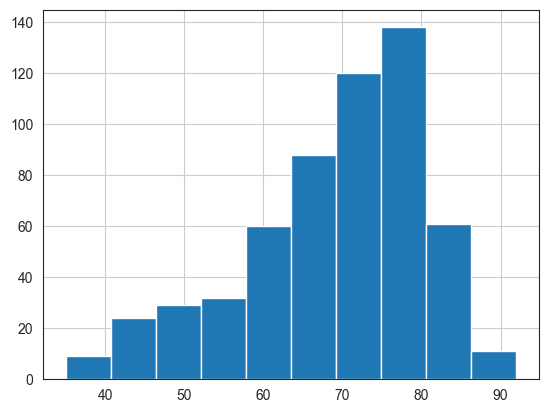

In [11]:
pheno['characteristics_ch1.1.age'].hist()

In [12]:
pheno.columns

Index(['title', 'status', 'submission_date', 'last_update_date', 'type',
       'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1',
       'characteristics_ch1.0.disease state', 'characteristics_ch1.1.age',
       'characteristics_ch1.2.gender', 'characteristics_ch1.3.ethnicity',
       'characteristics_ch1.4.tissue', 'molecule_ch1', 'extract_protocol_ch1',
       'label_ch1', 'label_protocol_ch1', 'hyb_protocol', 'scan_protocol',
       'data_processing', 'platform_id', 'contact_name', 'contact_email',
       'contact_laboratory', 'contact_department', 'contact_institute',
       'contact_address', 'contact_city', 'contact_state',
       'contact_zip/postal_code', 'contact_country', 'supplementary_file',
       'series_id', 'data_row_count', 'description'],
      dtype='object')

In [13]:
mat.shape

(486427, 571)

In [14]:
mat = mat.dropna(how="any") ### THIS REMOVES ~1/2 of the CpG. Consider removing with "all" and filling NaNs with Zero/Mean

In [15]:
mat.head(3)

,GSM3035401,GSM3035402,GSM3035403,GSM3035404,GSM3035405,GSM3035406,GSM3035407,GSM3035408,GSM3035409,GSM3035410,...,GSM3035963,GSM3035964,GSM3035965,GSM3035966,GSM3035967,GSM3035968,GSM3035969,GSM3035970,GSM3035971,GSM3035972
cg00000108,0.977816,0.972868,0.971075,0.972180,0.968020,0.972961,0.970523,0.966254,0.970028,0.975788,...,0.965072,0.973040,0.969568,0.971090,0.971595,0.966414,0.967109,0.974316,0.962038,0.966607
cg00000292,0.946824,0.929336,0.943428,0.895689,0.907283,0.898367,0.940528,0.908107,0.895068,0.911241,...,0.928202,0.910113,0.907877,0.902640,0.885221,0.911962,0.881744,0.924756,0.946721,0.942675
cg00000622,0.013283,0.013094,0.011795,0.011705,0.014471,0.013187,0.013816,0.012616,0.012346,0.011781,...,0.013587,0.013615,0.012084,0.012625,0.012093,0.012613,0.012596,0.012359,0.008448,0.011654


In [426]:
# class Dataset():
#     def __init__(self, gse_d, data_type="array"):
#         self.gse_d=gse_d
#         self.data_type=data_type
#         self.mat=None
#         self.groups=None
#         self.pheno=None

#     def load_data(self, max_CpGs=None):
#         # Load raw DNAm data and metadata into object
#         self.mat = pd.read_csv(os.path.join(self.gse_d, "matrix_beta.tsv"), index_col=0, sep="\t", nrows=max_CpGs)
#         self.groups = pd.read_csv(os.path.join(self.gse_d, "groups.csv"), index_col=0)
#         self.pheno = pd.read_csv(os.path.join(self.gse_d, "phenotypes.csv"), index_col=1)        

#     def add_target_lables(self):
#         # Rename targets (labels) of data to 0/1 instead of case/control, non-responders/responders etc.
#         orig_labels = self.groups.loc[self.mat.columns, "Group"]
#         label_names = orig_labels.unique()
#         if 'case' in label_names and 'control' in label_names:
#             self.y = orig_labels.apply(lambda x: 0 if x=="control" else 1) # Binary Series with case/controls as 1/0 

#     def organize_data(self):
#         # Organize input data for sklearn usage
#         self.df = self.mat.transpose() # mat is transposed (rows=CpGs, cols=Pats) -> .df is corrected
#         self.samps = list(df.index)
#         self.features =  list(df.columns)
#         self.add_target_lables() # Add y labels to self.y slot (0/1)


# def cv_train_test(Dataset, 
#                   CV = 5, # "LOO" # 10 #"LOO"
#                   penalty = 'l1', 
#                   internalCV_folds = 5,
#                   feat_selection="wilcox"
#                   ):
#     """ Perform CV training and evaluation on DNAm Dataset object """
#     # ----- Train model and get predictions -----
#     cv = LeaveOneOut() if CV=="LOO" else KFold(n_splits=CV)
#     X_tests, y_tests = [], []
#     models, y_preds, pred_probs = [], [], []
#     feats_used = [] # features selected in each fold
    
#     for fold, (train_index, test_index) in enumerate(cv.split(Dataset.df)):
#         # split df to train test (instead of np.array) for wilcoxon comparions (can be optimized for speed later)
#         df_train, df_test = Dataset.df.iloc[train_index], Dataset.df.iloc[test_index] 
#         y_train, y_test = Dataset.y[train_index], Dataset.y[test_index]
#         # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print("CV fold", fold, "Train size: %i, test size: %i (fract positives in train: %.3f)"%(df_train.shape[0], df_test.shape[0], y_train.mean()))
    
#         # Feature selection by wilcooxn:
#         if feat_selection=="wilcox":
#             mw_ps = stats.mannwhitneyu(df_train.iloc[np.where(y_train==0)[0], :], df_train.iloc[np.where(y_train==1)[0], :])[1]
#             feats_to_keep = list(compress(Dataset.features, np.where(mw_ps<0.05)[0]))
#             X_train = df_train.loc[:,feats_to_keep].values
#             X_test = df_test.loc[:, feats_to_keep].values 
#         else:
#             print("no feature selectin applied")
#             X_train = df_train.values
#             X_test = df_test.values
            
#         feats_used.append(feats_to_keep)
#         X_tests.append(X_test)
#         y_tests.append(y_test)
        
#         model, y_pred = helper.train_test(X_train, X_test, y_train, penalty=penalty, internalCV_folds=internalCV_folds)
#         models.append(model)
#         y_preds.append(list(y_pred))
#         pred_probs.append(model.predict_proba(X_test)[:,1])

#     # flatten prediction results from all folds into list
#     y_pred  = np.array([item for sublist in y_preds for item in sublist]) # predictions for entire dataset (aggregated across CV folds )
#     # preds_prob = np.array([item for sublist in pred_probs for item in sublist] )

#     outputs = {"CV":CV, "trained_models":models, "features_used":feats_used, "X_test_data":X_tests, "y_test":y_tests, "y_pred":y_pred, "y_pred_prob":pred_probs}
#     return (outputs)


# def plot_cv_roc(cv_res, out_f=None):
#     fprs, tprs, aucs = [], [], []
#     base_fpr = np.linspace(0, 1, 101)
#     plt.figure()
#     for i in range(len(cv_res['trained_models'])):
#         logit_roc_auc = roc_auc_score(cv_res["y_test"][i], cv_res["y_pred_prob"][i])
#         aucs.append(logit_roc_auc)
#         fpr, tpr, thresholds = roc_curve(cv_res["y_test"][i], cv_res["y_pred_prob"][i])
#         plt.plot(fpr, tpr, 'b', alpha=0.15)
#         tpr = np.interp(base_fpr, fpr, tpr)
#         tpr[0] = 0.0
#         tprs.append(tpr)
    
#     tprs = np.array(tprs)
#     mean_tprs = tprs.mean(axis=0)
#     std = tprs.std(axis=0)
#     tprs_upper = np.minimum(mean_tprs + std, 1)
#     tprs_lower = mean_tprs - std
#     mean_auc = np.mean(aucs)    

#     plt.plot(base_fpr, mean_tprs, 'darkblue', label="AUC=%0.2f"%mean_auc)
#     plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='lightgrey', alpha=0.3)    
#     plt.plot([0, 1], [0, 1],'k--')
#     plt.xlim([-0.01, 1.01])
#     plt.ylim([-0.01, 1.01])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.title('Receiver operating characteristic')
#     plt.legend(loc="lower right")
#     if out_f is not None:
#         plt.savefig(out_f)
#     plt.show()

In [423]:
data = Dataset(gse_d=gse_d)
data.load_data()#max_CpGs=5000) 
data.organize_data()

In [424]:
res = cv_train_test(data, 
                  CV = 5, # "LOO" # 10 #"LOO"
                  penalty = 'l1', 
                  internalCV_folds = 5)

CV fold 0 Train size: 456, test size: 115 (fract positives in train: 0.590)
CV fold 1 Train size: 457, test size: 114 (fract positives in train: 0.608)
CV fold 2 Train size: 457, test size: 114 (fract positives in train: 0.560)
CV fold 3 Train size: 457, test size: 114 (fract positives in train: 0.567)
CV fold 4 Train size: 457, test size: 114 (fract positives in train: 0.600)


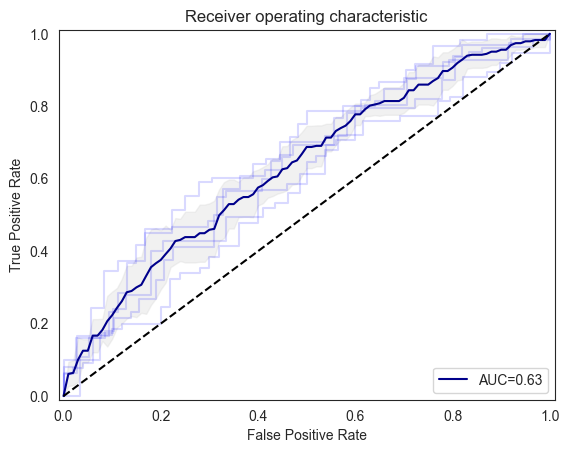

In [425]:
plot_cv_roc(cv_res)

### PCA 

#### Contrast each CpG between cases and controls

In [16]:
y = groups.loc[mat.columns, "Group"].apply(lambda x: 0 if x=="control" else 1) # Binary Series with case/controls as 1/0 

In [36]:
# Feature selection by Wilcoxon contrasting
def mw_p(mat, cpg):
    mw_p = stats.mannwhitneyu(mat.loc[cpg, y[y==0].index], mat.loc[cpg, y[y==1].index])[1]
    return(mw_p)

In [29]:
%%time
pvals = mat.apply(lambda x: mw_p(mat, cpg=x.name),1)

In [31]:
pvals.head()

cg00000108    0.035806
cg00000292    0.008870
cg00000622    0.678755
cg00000658    0.059434
cg00000714    0.070326
dtype: float64

In [32]:
pvals.shape

(237405,)

In [38]:
filt_mat = mat.loc[pvals[pvals<0.05].index, :]

In [39]:
filt_mat.shape

(45210, 571)

In [40]:
samps = list(filt_mat.columns)
features =  list(filt_mat.index)

y_df = groups.loc[samps, "Group"].apply(lambda x: 0 if x=="control" else 1)
y = y_df.values
x = filt_mat.values
x = np.transpose(x)


In [41]:
groups["Group"].value_counts()

Group
case       334
control    237
Name: count, dtype: int64

In [142]:
334/(334+237)

0.5849387040280211

In [42]:
print("Fract positives: %.3f"%(y.sum()/y.shape[0]))

Fract positives: 0.585


In [43]:
x.shape

(571, 45210)

In [44]:
x.mean(1).shape

(571,)

In [45]:
# Standardizing the features
x = StandardScaler().fit_transform(x)

# run PCA
pca = PCA(n_components=5)
pcs = pca.fit_transform(x)

# organize
df = pd.DataFrame(data = pcs,
                  index = samps, 
                  columns = ['PC'+str(i+1) for i in range(pcs.shape[1])])

# add pCR info
df = pd.concat([df, y_df], axis = 1)

In [49]:
df.head(3)

,PC1,PC2,PC3,PC4,PC5,Group
GSM3035401,-50.445927,-10.967333,-76.133069,38.404657,-19.510162,1
GSM3035402,96.577416,-24.410203,-38.989858,5.324173,-1.675844,0
GSM3035403,5.868975,-28.088359,-66.595190,22.944203,-2.133605,1


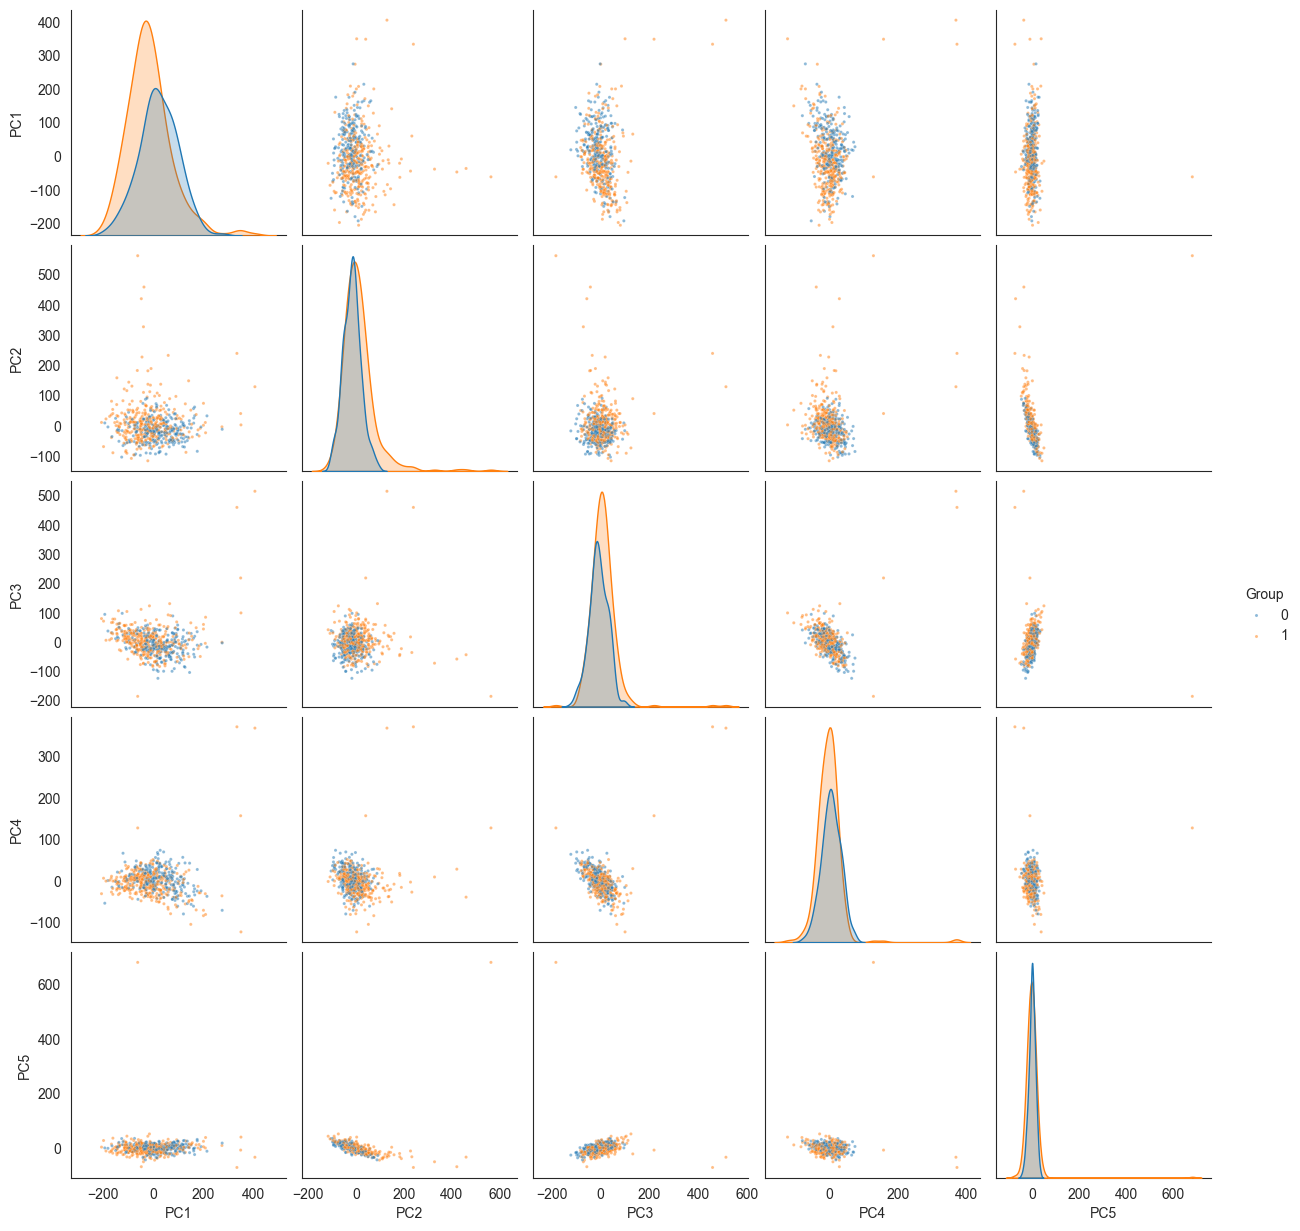

In [47]:
sns.pairplot(df, hue="Group", plot_kws={"s":5, "alpha":0.5});

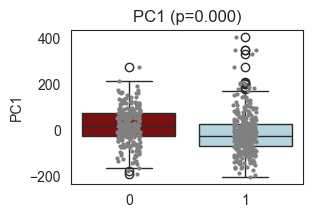

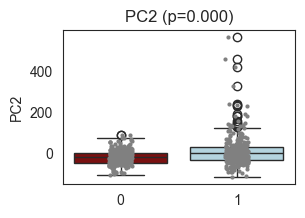

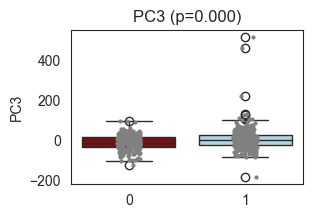

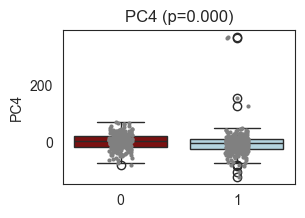

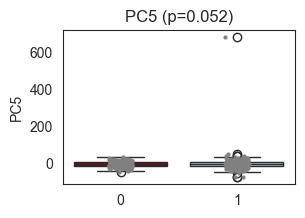

In [50]:
for pc in df.drop("Group", axis=1).columns:
    pval = stats.mannwhitneyu(df.loc[df["Group"]==0, pc], df.loc[df["Group"]==1, pc])[1]
    plt.figure(figsize=(3,2))
    sns.boxplot(data=df, x="Group", y=pc, order=[0,1], palette=["darkred", "lightblue"])
    sns.stripplot(data=df, x="Group", y=pc, order=[0,1], dodge=True, color="grey", s=3)
    plt.title("%s (p=%.3f)"%(pc, pval))
    plt.xlabel("")
    plt.show()

### Organize data for regression

In [18]:
from sklearn.model_selection import train_test_split


In [135]:
%%time
CV = 10 # "LOO" # 10 #"LOO"
penalty = 'l1'
internalCV_folds = 10

# ----- Train model and get predictions -----

# Organize input data before splitting
df = mat.transpose()
samps = list(df.index)
features =  list(df.columns)
y = groups.loc[samps, "Group"].apply(lambda x: 0 if x=="control" else 1).values

cv = LeaveOneOut() if CV=="LOO" else KFold(n_splits=CV)
models, y_preds, pred_probs = [], [], []
X_tests, y_tests = [], []
feats_used = [] # features selected in each fold
for fold, (train_index, test_index) in enumerate(cv.split(X)):
    # split df to train test (instead of np.array) for wilcoxon comparions (can be optimized for speed later)
    df_train, df_test = df.iloc[train_index], df.iloc[test_index] # mat is transposed (rows=CpGs, cols=Pats) -> df is corrected
    y_train, y_test = y[train_index], y[test_index]
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print("CV fold", fold, "Fraction of positives in train set: %.3f"%y_train.mean())

    # Feature selection by wilcooxn:
    mw_ps = stats.mannwhitneyu(df_train.iloc[np.where(y_train==0)[0], :], df_train.iloc[np.where(y_train==1)[0], :])[1]
    feats_to_keep = list(compress(features, np.where(mw_ps<0.05)[0]))
    
    X_train = df_train.loc[:,feats_to_keep].values
    X_test = df_test.loc[:, feats_to_keep].values 

    feats_used.append(feats_to_keep)
    X_tests.append(X_test)
    y_tests.append(y_test)
    
    model, y_pred = helper.train_test(X_train, X_test, y_train, penalty=penalty, internalCV_folds=internalCV_folds)
    models.append(model)
    y_preds.append(list(y_pred))
    pred_probs.append(model.predict_proba(X_test)[:,1])
    
y_pred  = np.array([item for sublist in y_preds for item in sublist])
preds_prob = np.array([item for sublist in pred_probs for item in sublist] )

CV fold 0 Fraction of positives in train set: 0.575
CV fold 1 Fraction of positives in train set: 0.599
CV fold 2 Fraction of positives in train set: 0.595
CV fold 3 Fraction of positives in train set: 0.595
CV fold 4 Fraction of positives in train set: 0.584
CV fold 5 Fraction of positives in train set: 0.564
CV fold 6 Fraction of positives in train set: 0.599
CV fold 7 Fraction of positives in train set: 0.554
CV fold 8 Fraction of positives in train set: 0.599
CV fold 9 Fraction of positives in train set: 0.584
CPU times: user 18min 52s, sys: 3min 57s, total: 22min 50s
Wall time: 18min 58s


In [141]:
[len (feats) for feats in feats_used]

[43501, 45219, 48847, 49074, 37024, 36888, 43978, 45687, 45608, 46049]

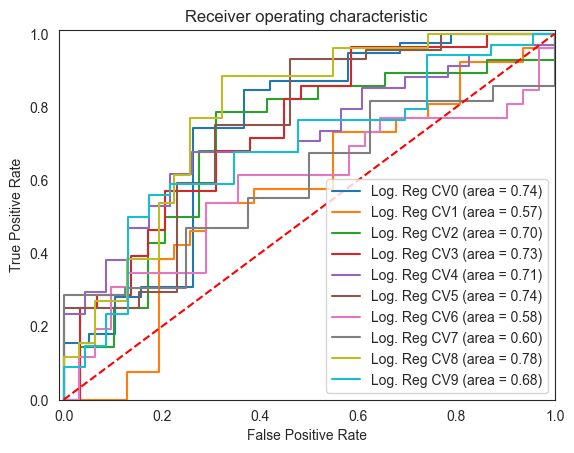

In [136]:
plt.figure()
for i in range(CV):#i=1
    logit_roc_auc = roc_auc_score(y_tests[i], pred_probs[i])
    fpr, tpr, thresholds = roc_curve(y_tests[i], pred_probs[i])
    plt.plot(fpr, tpr, label='Log. Reg CV%s (area = %0.2f)'%(str(i), logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
    # if out_f is not None:
#     plt.savefig(out_f)
plt.show()

#### Elastic Net for comparison

In [155]:
%%time
CV = 10 # "LOO" # 10 #"LOO"
penalty = 'elasticnet' # 'l1'# 'elasticnet'
internalCV_folds = 10

# ----- Train model and get predictions -----

# Organize input data before splitting
df = mat.transpose()
samps = list(df.index)
features =  list(df.columns)
y = groups.loc[samps, "Group"].apply(lambda x: 0 if x=="control" else 1).values

cv = LeaveOneOut() if CV=="LOO" else KFold(n_splits=CV)
models, y_preds, pred_probs = [], [], []
X_tests, y_tests = [], []
feats_used = [] # features selected in each fold
for fold, (train_index, test_index) in enumerate(cv.split(X)):
    # split df to train test (instead of np.array) for wilcoxon comparions (can be optimized for speed later)
    df_train, df_test = df.iloc[train_index], df.iloc[test_index] # mat is transposed (rows=CpGs, cols=Pats) -> df is corrected
    y_train, y_test = y[train_index], y[test_index]
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print("CV fold", fold, "Fraction of positives in train set: %.3f"%y_train.mean())

    # Feature selection by wilcooxn:
    mw_ps = stats.mannwhitneyu(df_train.iloc[np.where(y_train==0)[0], :], df_train.iloc[np.where(y_train==1)[0], :])[1]
    feats_to_keep = list(compress(features, np.where(mw_ps<0.05)[0]))
    
    X_train = df_train.loc[:,feats_to_keep].values
    X_test = df_test.loc[:, feats_to_keep].values 

    feats_used.append(feats_to_keep)
    X_tests.append(X_test)
    y_tests.append(y_test)
    
    model, y_pred = helper.train_test(X_train, X_test, y_train, penalty=penalty, internalCV_folds=internalCV_folds)
    models.append(model)
    y_preds.append(list(y_pred))
    pred_probs.append(model.predict_proba(X_test)[:,1])
    
y_pred  = np.array([item for sublist in y_preds for item in sublist])
preds_prob = np.array([item for sublist in pred_probs for item in sublist] )

CV fold 0 Fraction of positives in train set: 0.575


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 1 Fraction of positives in train set: 0.599


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 2 Fraction of positives in train set: 0.595


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 3 Fraction of positives in train set: 0.595


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 4 Fraction of positives in train set: 0.584


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 5 Fraction of positives in train set: 0.564


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 6 Fraction of positives in train set: 0.599


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

CV fold 7 Fraction of positives in train set: 0.554


/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erankotler/miniconda3/envs/geo_cpg/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

KeyboardInterrupt: 

In [ ]:
plt.figure()
for i in range(CV):#i=1
    logit_roc_auc = roc_auc_score(y_tests[i], pred_probs[i])
    fpr, tpr, thresholds = roc_curve(y_tests[i], pred_probs[i])
    plt.plot(fpr, tpr, label='Log. Reg CV%s (area = %0.2f)'%(str(i), logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
    # if out_f is not None:
#     plt.savefig(out_f)
plt.show()

# HERE Night

In [163]:
a = Dataset()

In [164]:
a

In [ ]:
LogisticRegressionCV(

#### Elastic Net (Simple train-test split)

In [144]:
from sklearn.linear_model import ElasticNetCV

In [65]:
regr = ElasticNetCV(cv=5, random_state=0, n_jobs=10)
regr.fit(X_train, y_train)

ElasticNetCV(cv=5, random_state=0)

In [66]:
print(regr.alpha_)

0.002795110434645956


In [67]:
print(regr.intercept_)

2.1919390540077583


In [72]:
regr.mse_path_.shape

(100, 5)

In [73]:
regr.alphas_.shape

(100,)

In [75]:
regr.

45210

In [79]:
regr.alphas_.max()

0.03694971498065255

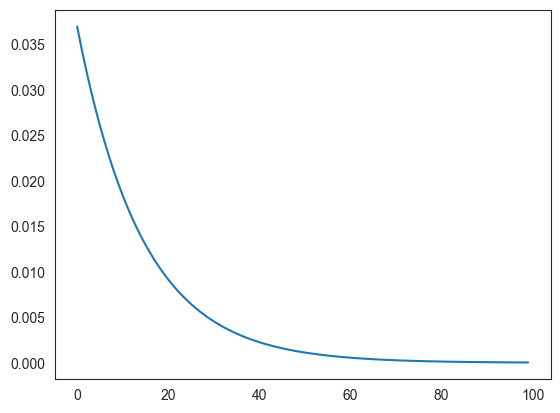

In [77]:
plt.plot(regr.alphas_)

In [80]:
y_pred = regr.predict(X_test)

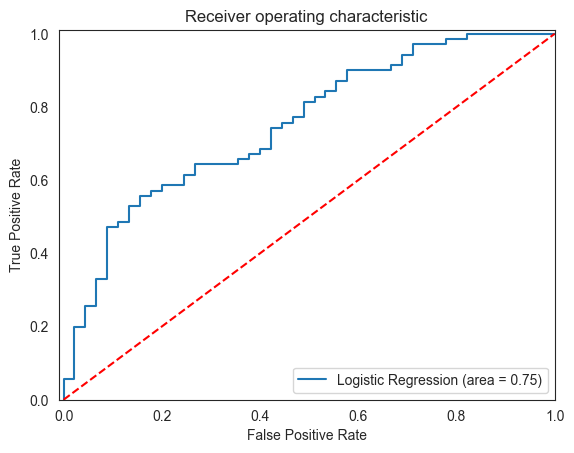

In [95]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# if out_f is not None:
#     plt.savefig(out_f)
plt.show()

In [122]:
THRESH = 0.4 #0.567459


In [128]:
classification_report(y_test, y_pred>THRESH)

'              precision    recall  f1-score   support\n\n           0       0.65      0.49      0.56        45\n           1       0.72      0.83      0.77        70\n\n    accuracy                           0.70       115\n   macro avg       0.68      0.66      0.66       115\nweighted avg       0.69      0.70      0.69       115\n'

In [123]:
print(classification_report(y_test, y_pred>THRESH))

              precision    recall  f1-score   support

           0       0.65      0.49      0.56        45
           1       0.72      0.83      0.77        70

    accuracy                           0.70       115
   macro avg       0.68      0.66      0.66       115
weighted avg       0.69      0.70      0.69       115



In [100]:
y_test.astype(float)

array([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.])

#### Lasso with internal CV 

In [167]:
%%time
CV = 10 # "LOO" # 10 #"LOO"
penalty = 'l1'
internalCV_folds = 10

# ----- Train model and get predictions -----
cv = LeaveOneOut() if CV=="LOO" else KFold(n_splits=CV)
models, y_preds, pred_probs = [], [], []
X_tests, y_tests = [], []
for fold, (train_index, test_index) in enumerate(cv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("CV fold", fold, "Fraction of positives in train set: %.3f"%y_train.mean())

    X_tests.append(X_test)
    y_tests.append(y_test)
    
    model, y_pred = helper.train_test(X_train, X_test, y_train, penalty=penalty, internalCV_folds=internalCV_folds)
    models.append(model)
    y_preds.append(list(y_pred))
    pred_probs.append(model.predict_proba(X_test)[:,1])
    
y_pred  = np.array([item for sublist in y_preds for item in sublist])
preds_prob = np.array([item for sublist in pred_probs for item in sublist] )

CV fold 0 Fraction of positives in train set: 0.575
CV fold 1 Fraction of positives in train set: 0.599
CV fold 2 Fraction of positives in train set: 0.595
CV fold 3 Fraction of positives in train set: 0.595
CV fold 4 Fraction of positives in train set: 0.584
CV fold 5 Fraction of positives in train set: 0.564
CV fold 6 Fraction of positives in train set: 0.599
CV fold 7 Fraction of positives in train set: 0.554
CV fold 8 Fraction of positives in train set: 0.599
CV fold 9 Fraction of positives in train set: 0.584
CPU times: user 11min 40s, sys: 3min 57s, total: 15min 38s
Wall time: 11min 25s


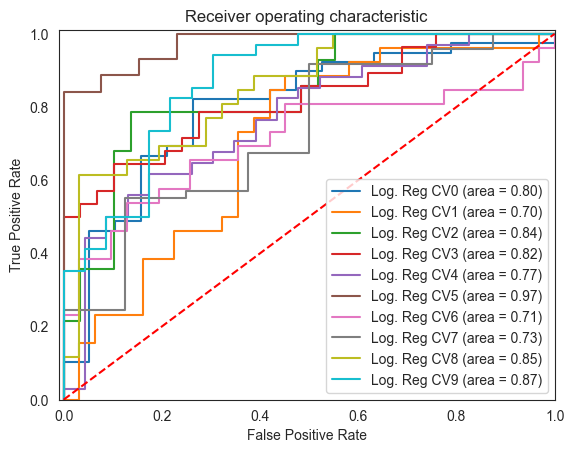

In [168]:
plt.figure()
for i in range(CV):#i=1
    logit_roc_auc = roc_auc_score(y_tests[i], pred_probs[i])
    fpr, tpr, thresholds = roc_curve(y_tests[i], pred_probs[i])
    plt.plot(fpr, tpr, label='Log. Reg CV%s (area = %0.2f)'%(str(i), logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
    # if out_f is not None:
#     plt.savefig(out_f)
plt.show()

# HERE

TODO - avg Accuracy over CVs

In [158]:
ys = np.array([item for sublist in y_tests for item in sublist])

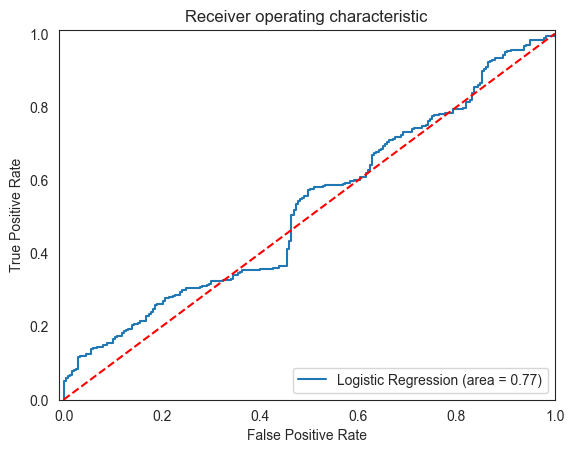

In [159]:
helper.plot_roc_curve(ys, y_pred, preds_prob, out_f=None)

In [ ]:
helper.plot_roc_curve(y_tests[i], y_preds[i], pred_probs[i], out_f=None)

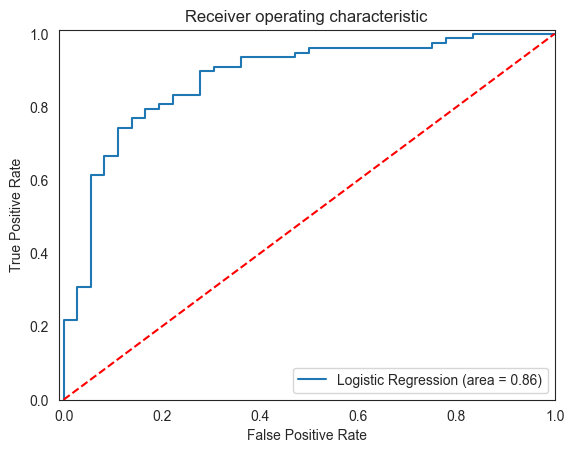

In [156]:
i=2
helper.plot_roc_curve(y_tests[i], y_preds[i], pred_probs[i], out_f=None)

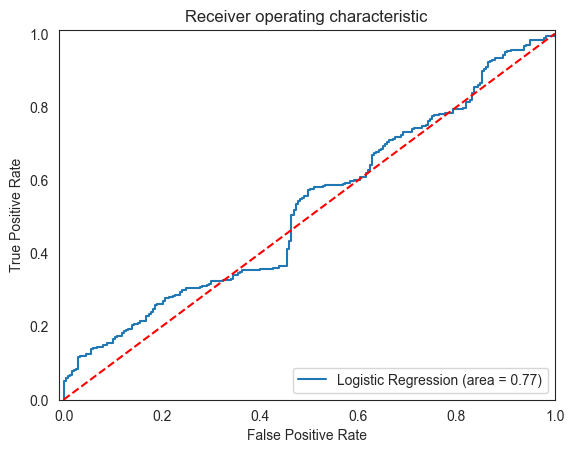

In [145]:
helper.plot_roc_curve(y, y_pred, preds_prob, out_f=None)

In [131]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((457, 45210), (114, 45210), (457,), (114,))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       237
           1       0.80      0.83      0.81       334

    accuracy                           0.78       571
   macro avg       0.77      0.77      0.77       571
weighted avg       0.78      0.78      0.78       571



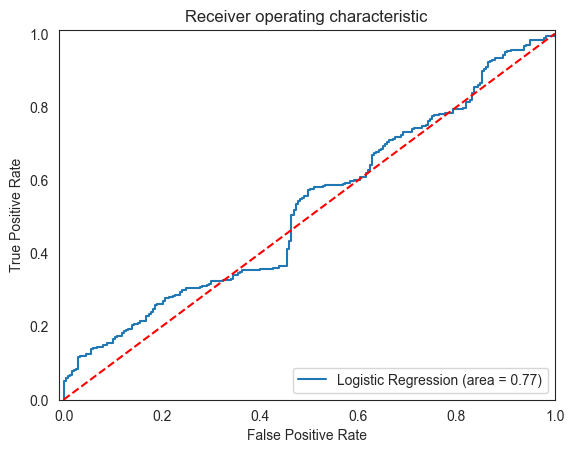

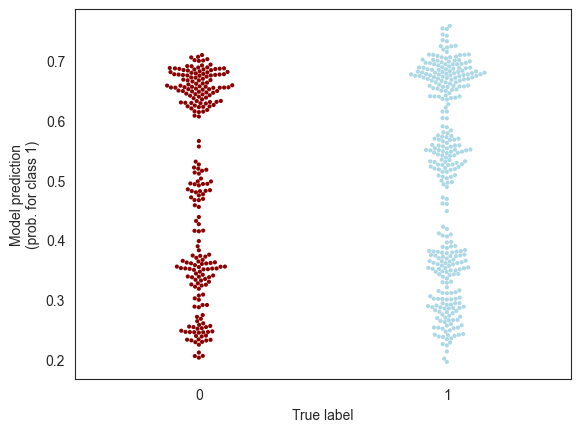

In [132]:
print(classification_report(y, y_pred))

helper.plot_roc_curve(y, y_pred, preds_prob, out_f=None)

sns.swarmplot(x=y, y=preds_prob, size=3, palette=["darkred","lightblue"])
plt.xlabel("True label")
plt.ylabel("Model prediction\n(prob. for class 1)")
plt.show()

In [166]:
# Regularization lambdas across models (lower=stronger regularization):
Cs = pd.DataFrame([m.C_ for m in models], columns=["C"])
Cs["C"].value_counts()

C
2.782559     3
35.938137    2
Name: count, dtype: int64